<a href="https://colab.research.google.com/github/Yang-yamper/research-for-graduation/blob/main/Resnet%E3%81%AE%E5%AE%9F%E8%A3%85%EF%BC%88%E3%81%8B%E3%82%8B%E3%81%9F)%E3%80%80%E3%82%AC%E3%83%81%E3%80%80res_block%3D%EF%BC%93%E3%81%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import keras
from tqdm import tqdm, tqdm_notebook
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras.layers import Add, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from PIL import Image
import os, glob
import numpy as np
import random, math

#画像が保存されているルートディレクトリのパス
root_dir = "/content/drive/MyDrive/result_range"
# 商品名
categories = ["left","right"]

# 画像データ用配列
X = []
# ラベルデータ用配列
Y = []

#画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

#渡された画像データを読み込んでXに格納し、また、
#画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((224,224))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

#全データ格納用配列
allfiles = []

#カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

#シャッフル後、学習データと検証データに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.8)
train = allfiles[0:th]
test  = allfiles[th:]
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)
xy = (X_train, X_test, y_train, y_test)
#データを保存する（データの名前を「tea_data.npy」としている）
np.save("/content/drive/MyDrive/tea_data.npy", xy)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [5]:
from keras.utils import np_utils
import numpy as np

categories = ["left","right"]
nb_classes = len(categories)

X_train, X_test,y_train, y_test = np.load("/content/drive/MyDrive/tea_data.npy", allow_pickle=True)

#データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float")  / 255

#kerasで扱えるようにcategoriesをベクトルに変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)

In [17]:
#res block
def resblock(x, filters, kernel_size):
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x_ = BatchNormalization()(x_)
    x_ = Activation("relu")(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#cnnの構築
input_ = Input(shape=(224,224,3))#横の数、縦の数、RGB

c = Conv2D(8, (3,3), padding='same')(input_)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = resblock(c,filters=8,kernel_size=(3, 3))
c = MaxPooling2D(pool_size=(2,2))(c)
c = Conv2D(8, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = resblock(c,filters=8, kernel_size=(3, 3))
c = MaxPooling2D(pool_size=(2,2))(c)
c = Conv2D(8, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = resblock(c,filters=8, kernel_size=(3, 3))
c = MaxPooling2D(pool_size=(2,2))(c)
c = Flatten()(c)
c = Dense(256, activation='relu')(c)
c = Dropout(0.2)(c)
c = Dense(2, activation='sigmoid')(c)

model = Model(input_, c)

model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4),metrics=["acc"])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_75 (Conv2D)             (None, 224, 224, 8)  224         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_71 (BatchN  (None, 224, 224, 8)  32         ['conv2d_75[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [26]:
history = model.fit(X_train, y_train
                   , batch_size = 20
                   , epochs = 30
                   , validation_split = 0.3
                   , verbose = 1)

Epoch 1/30
41/41 [==============================] - 122s 2s/step - loss: 0.5506 - acc: 0.7540 - val_loss: 0.6921 - val_acc: 0.5556
Epoch 2/30
41/41 [==============================] - 68s 2s/step - loss: 0.3927 - acc: 0.8592 - val_loss: 0.6877 - val_acc: 0.5556
Epoch 3/30
41/41 [==============================] - 64s 2s/step - loss: 0.3007 - acc: 0.8935 - val_loss: 0.6826 - val_acc: 0.5556
Epoch 4/30
41/41 [==============================] - 65s 2s/step - loss: 0.2576 - acc: 0.9143 - val_loss: 0.6794 - val_acc: 0.5556
Epoch 5/30
41/41 [==============================] - 64s 2s/step - loss: 0.2201 - acc: 0.9253 - val_loss: 0.6707 - val_acc: 0.5556
Epoch 6/30
41/41 [==============================] - 65s 2s/step - loss: 0.1876 - acc: 0.9388 - val_loss: 0.6706 - val_acc: 0.5556
Epoch 7/30
41/41 [==============================] - 64s 2s/step - loss: 0.1622 - acc: 0.9486 - val_loss: 0.6656 - val_acc: 0.5556
Epoch 8/30
41/41 [==============================] - 67s 2s/step - loss: 0.1379 - acc: 0.9

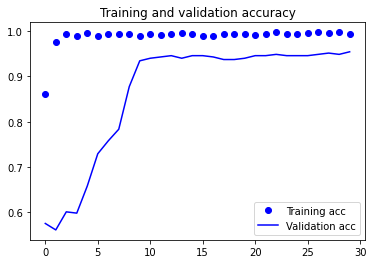

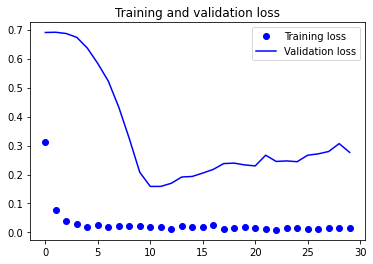

In [ ]:
from keras import layers, models
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('property')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss')

In [27]:
from PIL import Image
import os, glob
import numpy as np
import random, math

# 画像が保存されているディレクトリのパス
root_dir = "/content/drive/MyDrive/result_range"
# 画像が保存されているフォルダ名
categories =["left","right"]

X = [] # 画像データ
Y = [] # ラベルデータ

# フォルダごとに分けられたファイルを収集
#（categoriesのidxと、画像のファイルパスが紐づいたリストを生成）
allfiles = []
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

for cat, fname in allfiles:
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((224,224))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

x = np.array(X)
y = np.array(Y)

np.save("/content/drive/MyDrive/tea_data_test_X_150.npy", x)
np.save("/content/drive/MyDrive/tea_data_test_Y_150.npy", y)

In [28]:
# モデルの精度を測る

#評価用のデータの読み込み
test_X = np.load("/content/drive/MyDrive/tea_data_test_X_150.npy")
test_Y = np.load("/content/drive/MyDrive/tea_data_test_Y_150.npy")

#Yのデータをone-hotに変換
from keras.utils import np_utils

test_Y = np_utils.to_categorical(test_Y, 2)

score = history.model.evaluate(x=test_X,y=test_Y)

print('loss=', score[0])
print('accuracy=', score[1])

46/46 [==============================] - 31s 671ms/step - loss: 322.2391 - acc: 0.6329
loss= 322.2391357421875
accuracy= 0.6328766942024231
